# Twitter Example
Using the Twitter Developer API  and PySpark to highlight twitter #hashtag trends

In [1]:
import findspark
findspark.init('/home/matt/spark-3.1.1-bin-hadoop2.7')

In [2]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [3]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [4]:
ssc = StreamingContext(sc, 10) # how many tweets to analyse
sqlContext = SQLContext(sc)

In [5]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [6]:
lines = socket_stream.window(20)

In [ ]:
#lines.flatMap( lambda text: text.split( " " )).pprint()

In [7]:
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple('Tweet', fields )

In [8]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(100).registerTempTable("tweets") ) ) # Registers to a table.


## Run TweetRead.py
-Before running below cells, go to terminal and run $ python3 TweetRead.py 
-Change filter options to focus on specific hastags

In [9]:
ssc.start()    

In [10]:
# ignore warnings related to language characters
import warnings
warnings.filterwarnings("ignore")

import time
from IPython import display

# for fast string concatination
from io import StringIO

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Only works for Jupyter Notebooks!
%matplotlib inline 

## Plot word cloud of tweets relating to Covid-19

In [12]:
#time.sleep(10)
# Check stream with one tweet
tweets = sqlContext.sql( 'Select tag, count from tweets' )

In [17]:
df = tweets.toPandas()

In [18]:
si = StringIO()
df['tag'].apply(lambda x:si.write(str(x)))
s = si.getvalue()
si.close()

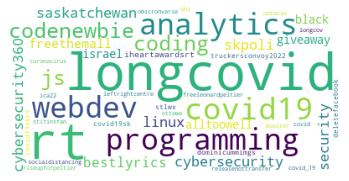

In [19]:
wordcloud = WordCloud(background_color="white",max_words=len(s),max_font_size=60, relative_scaling=.8).generate(s)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Real-time tweets

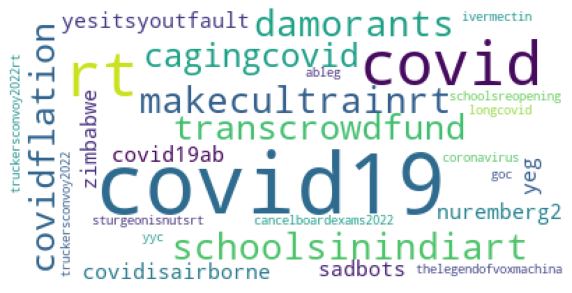

In [20]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    tweets = sqlContext.sql( 'Select tag, count from tweets' )
    df = tweets.toPandas()
    
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    #sns.barplot( x="count", y="tag", data=top_10_df)
    
    # create text for word cloud
    si = StringIO()
    df['tag'].apply(lambda x:si.write(str(x)))
    s = si.getvalue()
    si.close()
    
    # generate word cloud    
    wordcloud = WordCloud(background_color="white",max_words=len(s),max_font_size=60, relative_scaling=.8).generate(s)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    count = count + 1

In [21]:
ssc.stop()